## Set up and read the input file

We first import all necessary classes and read the input file. While reading the input file, we count the observation using the matrix model by supplying the class CountMatrixModel.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import inputFile.inputFile as inputFile
import spoke_model.countMatrixModel as cmm
import meanfield.simulateLikelihood as smlt

fileName = "gavin2006.csv"
print('Hello, ' + fileName)
inputSet = inputFile.CInputSet(fileName, cmm.CountMatrixModel)

Hello, gavin2006.csv
Number of proteins 2760
Number of purifications 2166


## Parameter search

Our formulation reduces the two parameters FN and FP to the log-ratio $\psi$ which simplifies the parameter search. We set the search interval to be $(2.2, 13.5)$ which approximately has the domain of FN = $[0.1, 0.7]$ and FP = $[0.001,0.006]$ 
To search for a good $\psi$, we run a simple hill-climbing search until no further improvement is found.
We compute both the negative log-likelihood and the AIC. 

In [2]:
from time import time as timer

def hill_climbing(inputSet, Nk, step=0.5):

    nProteins = inputSet.observationG.nProteins
    cmfa = smlt.CMeanFieldAnnealing(nProteins, Nk) # default

    funcInfer = cmfa        

    funcInfer.estimate(inputSet.observationG, nProteins, Nk, 0.3)
    (fn, fp, errs, f_last) = funcInfer.computeErrorRate(inputSet.observationG, nProteins)
    x_values = np.arange(1.0, 10.5, step)
    y_values = np.zeros(len(x_values), dtype=float)
    aics = np.zeros(len(x_values), dtype=float) 
    for i, psi in enumerate(x_values):
        ts = timer()
        f_value = funcInfer.estimate(inputSet.observationG, nProteins, Nk, psi) 
        te = timer()
        print("Time running MFA: ", te-ts)
        print("x = ", psi, "f(x) = ", f_value)
        (fn, fp, errs, likelihood) = funcInfer.computeErrorRate(inputSet.observationG, nProteins)
        print("\tLikelihood =", likelihood)
        y_values[i] = likelihood
        aics[i] = (Nk - likelihood)/(Nk - f_last)
        f_last = likelihood

    return (x_values, aics, y_values)

x_values, aics, y_values = hill_climbing(inputSet, 300, step=0.2)

psi =  0.3
Initialize with MFA: num. iterations =  10
Indicator matrix had rank = 300
Number of clusters used: 300
psi =  1.0
Initialize with MFA: num. iterations =  10
Time running MFA:  74.5302050113678
x =  1.0 f(x) =  80741021041.99998
Indicator matrix had rank = 300
Number of clusters used: 300
	Likelihood = 745293956.2484934
psi =  1.2
Initialize with MFA: num. iterations =  10
Time running MFA:  78.8320951461792
x =  1.2 f(x) =  96312310151.99983
Indicator matrix had rank = 300
Number of clusters used: 300
	Likelihood = 724856067.9276842
psi =  1.4
Initialize with MFA: num. iterations =  10
Time running MFA:  79.06990480422974
x =  1.4 f(x) =  111883599262.0001
Indicator matrix had rank = 300
Number of clusters used: 300
	Likelihood = 710444510.6384034
psi =  1.5999999999999999
Initialize with MFA: num. iterations =  10
Time running MFA:  78.49785876274109
x =  1.5999999999999999 f(x) =  127454888371.99991
Indicator matrix had rank = 300
Number of clusters used: 300
	Likelihood 

## Plot the negative log-likelihood and the AIC

We first filter the raw data, before we locate the inflection points. Here, the inflection points define values where the gradient change direction.
Since $\psi$ and the number of clusters are related, we will later fix $\psi$ and run another search on a number of clusters.
Smaller $\psi$ results in splitting up clusters, while larger $\psi$ tends to merge clusters.

In [3]:
%matplotlib inline

psi =  [ 2.   2.4  3.   3.4  4.4  4.8  5.6  6.2  7.6  8.6  9.2  9.6 10.2]


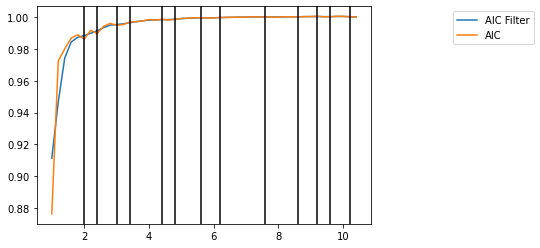

In [4]:
from scipy.ndimage import gaussian_filter1d
aics_filter = gaussian_filter1d(aics, 1)
y_values = y_values/np.max(y_values)
y_filter = gaussian_filter1d(y_values, 1)
d2 = np.gradient(np.gradient(y_filter))
aics_d2 = np.gradient(np.gradient(aics_filter))
infls = np.where(np.diff(np.sign(aics_d2)))[0]
print("psi = ", x_values[infls])

fig = plt.figure()
plt.plot(x_values, aics_filter, label='AIC Filter')
plt.plot(x_values, aics, label='AIC')
for i, infl in enumerate(infls):
    plt.axvline(x=x_values[infl], color='k')
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

## Number of clusters

In this example, we select the first inflection point where $\psi> 2$ and plot the log-likelihood (scaled). Ideally, When adding more clusters does not improve the relative log-likelihood, we have found a solution. In practice, there exist local optimas and we select the solution with more clusters. Given $\psi$, the log-likelihood should stay at a minimum if the maximum number of clusters given is high enough to allow empty clusters. The MFA can automatically truncate the solution. 

In [10]:
def clustering(inputSet, k, psi):
    nProteins = inputSet.observationG.nProteins
    cmfa = smlt.CMeanFieldAnnealing(nProteins, k) # default

    funcInfer = cmfa        

    funcInfer.estimate(inputSet.observationG, nProteins, k, psi)
    (fn, fp, errs, f_last) = funcInfer.computeErrorRate(inputSet.observationG, nProteins)
    return f_last

max_k = int(inputSet.observationG.nProteins/2)
ks = np.arange(100, max_k, 100)
for infl in infls[:3]:
    ls = []
    for i, k in enumerate(ks):
        ls.append(clustering(inputSet, k, x_values[infl]))
    ls = ls/np.max(ls)
    plt.plot(ks, ls, label="{:.2f}".format(x_values[infl]))
plt.ylim(0.95, 1.0)
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer